<a href="https://colab.research.google.com/github/iwmysihyhe/Travel-guide/blob/main/cw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.sparse import diags, kron

def lap_mat_2d(n):
    main_diag = -4 * np.ones(n * n)
    side_diag = np.ones(n * n - 1)
    side_diag[np.arange(1, n * n) % n == 0] = 0
    up_down_diag = np.ones(n * n - n)

    diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
    offsets = [0, 1, -1, n, -n]

    lap_2d = diags(diagonals, offsets, format="csr")
    return lap_2d

In [2]:
def exp_timestep_2d(CA, u):
  return u + CA @ u


In [3]:
def boundary_conditions(u, N):

  u = u.reshape((N, N))
  u[:, 0] = 5
  u[:, -1] = 0
  u[0, :] = 0
  u[-1, :] = 0
  return u.flatten()





In [4]:
def solve_2d_heat_exp(u_0, T, delta_x, delta_t, alpha):
    N = int(len(u_0)**0.5)
    time_steps = int(T / delta_t)
    r = alpha * delta_t / delta_x**2
    if r > 0.25:
        raise ValueError("Explicit method is unstable (r > 0.25). Adjust delta_t or delta_x.")

    A = lap_mat_2d(N)
    CA = r * A

    u = u_0.copy()
    usteps = [u.copy()]

    center_idx = (N // 2) * N + (N // 2)

    target_time = None

    for t in range(time_steps):
        u = exp_timestep_2d(CA, u)
        u = boundary_conditions(u, N)
        usteps.append(u.copy())

        if target_time is None and u[center_idx] >= 1:
            target_time = t * delta_t

    return target_time


In [5]:
N = 120
delta_x = 2 / N
delta_t = 0.00005
alpha = 1
T = 2

u_0 = np.zeros((N, N))
u_0[:, 0] = 5
u_0 = u_0.flatten()

t = solve_2d_heat_exp(u_0, T, delta_x, delta_t, alpha)

if t is not None:
    print(f"The target time t* (center reaches u=1) is approximately {t:.12f} seconds.")
else:
    print("The target temperature was not reached within the simulated time.")


The target time t* (center reaches u=1) is approximately 0.431200000000 seconds.


Comment: The code above showed an explicit time-stepping method to solve this heat equation by using CPU.

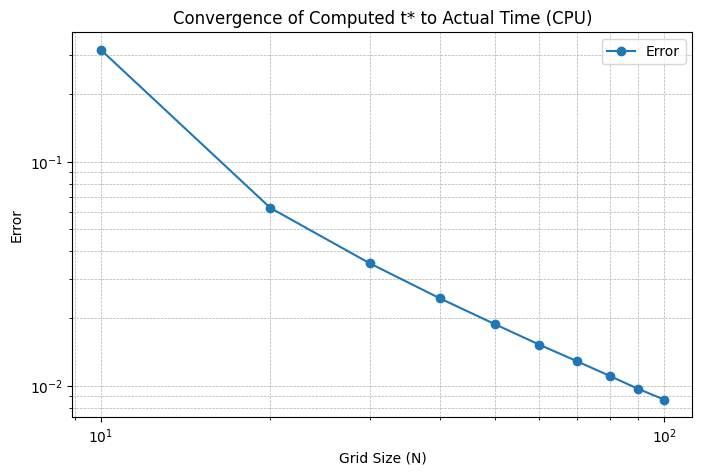

In [13]:
import matplotlib.pyplot as plt
t_real =0.424011387033

grid_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
t = []
for N in grid_sizes:

    delta_x = 2 / N
    delta_t = 0.0001
    alpha = 1
    T = 2

    u_0 = np.zeros((N, N), dtype=np.float32)
    u_0[:, 0] = 5
    u_0 = u_0.flatten()

    t_cal = solve_2d_heat_exp(u_0, delta_x, delta_t, alpha)

    t.append(t_cal)

errors = [abs(t_cal - t_real) for t_cal in t]

plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, errors, marker="o", label="Error")
plt.xlabel("Grid Size (N)")
plt.ylabel("Error")
plt.title("Convergence of Computed t* to Actual Time (CPU)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Comment: Here is the plot about the convergence of computed time t
 against the actual time.

Testing with delta_t = 0.0001...
Stability parameter r = 0.0625
Testing with delta_t = 0.0010...
Stability parameter r = 0.6250
Testing with delta_t = 0.0100...
Stability parameter r = 6.2500
Testing with delta_t = 0.0200...
Stability parameter r = 12.5000

Stability Results:
delta_t = 0.0001, r = 0.0625, Status: Stable
delta_t = 0.0010, r = 0.6250, Status: Unstable
delta_t = 0.0100, r = 6.2500, Status: Unstable
delta_t = 0.0200, r = 12.5000, Status: Unstable


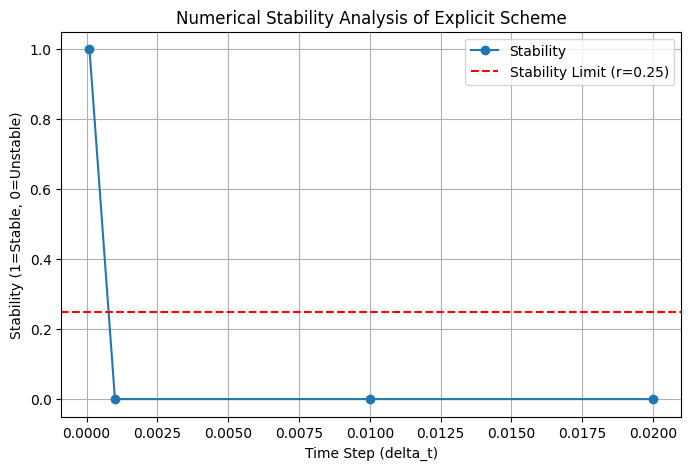

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def solve_2d_heat_stability(u_0, T, delta_x, delta_t, alpha, N):
    """
    用显式方法求解二维热方程，并检查稳定性。
    """
    r = alpha * delta_t / delta_x**2
    print(f"Stability parameter r = {r:.4f}")

    # 构建二维拉普拉斯矩阵
    A = lap_mat_2d(N)
    CA = r * A

    # 初始化温度场
    u = u_0.copy()
    time_steps = int(T / delta_t)

    # 时间步进
    for t in range(time_steps):
        u = exp_timestep_2d(CA, u)
        u = boundary_conditions(u, N)

        # 检查是否出现非物理解（发散）
        if np.any(np.abs(u) > 1e6):  # 假设超过 1e6 表示解发散
            return False, r  # 不稳定

    return True, r  # 稳定

# 参数设置
N = 50
alpha = 1
T = 2
u_0 = np.zeros((N, N))
u_0[:, 0] = 5
u_0 = u_0.flatten()

# 测试不同的 delta_t 和 delta_x
delta_x = 2 / N
delta_t_values = [0.0001, 0.001, 0.01, 0.02]  # 不同的时间步长

stability_results = []
for delta_t in delta_t_values:
    print(f"Testing with delta_t = {delta_t:.4f}...")
    is_stable, r = solve_2d_heat_stability(u_0, T, delta_x, delta_t, alpha, N)
    stability_results.append((delta_t, r, is_stable))

# 打印结果
print("\nStability Results:")
for delta_t, r, is_stable in stability_results:
    status = "Stable" if is_stable else "Unstable"
    print(f"delta_t = {delta_t:.4f}, r = {r:.4f}, Status: {status}")

# 可视化稳定性分析
delta_t_values, r_values, stabilities = zip(*stability_results)
stabilities_numeric = [1 if stable else 0 for stable in stabilities]

plt.figure(figsize=(8, 5))
plt.plot(delta_t_values, stabilities_numeric, marker="o", label="Stability")
plt.axhline(0.25, color="red", linestyle="--", label="Stability Limit (r=0.25)")
plt.xlabel("Time Step (delta_t)")
plt.ylabel("Stability (1=Stable, 0=Unstable)")
plt.title("Numerical Stability Analysis of Explicit Scheme")
plt.legend()
plt.grid()
plt.show()


Comment: This is the numerical investigation of the stability of the schemes. When the value of r is samller or equals to 0.25, the scheme is stable.

In [3]:
import numpy as np
from numba import cuda

@cuda.jit
def exp_timestep_2d_kernel(u, u_new, N, r):
    i, j = cuda.grid(2)
    if 1 <= i < N - 1 and 1 <= j < N - 1:
        u_new[i, j] = (
            r * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4 * u[i, j])
            + u[i, j]
        )

@cuda.jit
def boundary_conditions_kernel(u, N):
    i, j = cuda.grid(2)
    if i == 0 or i == N-1 or j == 0 or j == N-1:
        if j == 0:
            u[i, j] = 5
        else:
            u[i, j] = 0

def solve_2d_heat_exp_GPU(u_0, T, delta_x, delta_t, alpha, N):

    r = alpha * delta_t / delta_x**2
    if r > 0.25:
        raise ValueError("Stability condition violated: r > 0.25")

    u = cuda.to_device(u_0)
    u_new = cuda.device_array_like(u)

    threads_per_block = (16, 16)
    threads_per_block = (16, 16)
    blocks_per_grid = ((N + threads_per_block[0] - 1) // threads_per_block[0], (N + threads_per_block[1] - 1) // threads_per_block[1])

    time_steps = int(T / delta_t)
    center_idx = (N // 2, N // 2)
    target_time = None

    for t in range(time_steps):
        boundary_conditions_kernel[blocks_per_grid, threads_per_block](u, N)

        exp_timestep_2d_kernel[blocks_per_grid, threads_per_block](u, u_new, N, r)

        u, u_new = u_new, u

        if target_time is None and u[center_idx] >= 1:
            target_time = t * delta_t

    u_final = u.copy_to_host()
    return target_time

In [3]:


N = 1000
delta_x = 2 / N
delta_t = 0.000001
alpha = 1
T = 2

u_0 = np.zeros((N, N), dtype=np.float32)
u_0[:, 0] = 5

target_time = solve_2d_heat_exp_GPU(u_0, T, delta_x, delta_t, alpha, N)

if target_time is not None:
    print(f"The target time t (center reaches u=1) is approximately {target_time:.6f} seconds.")
else:
    print("The target temperature was not reached within the simulated time.")




The target time t (center reaches u=1) is approximately 0.424902 seconds.


Comment: The code above showed an explicit time-stepping method to solve this heat equation by using GPU.

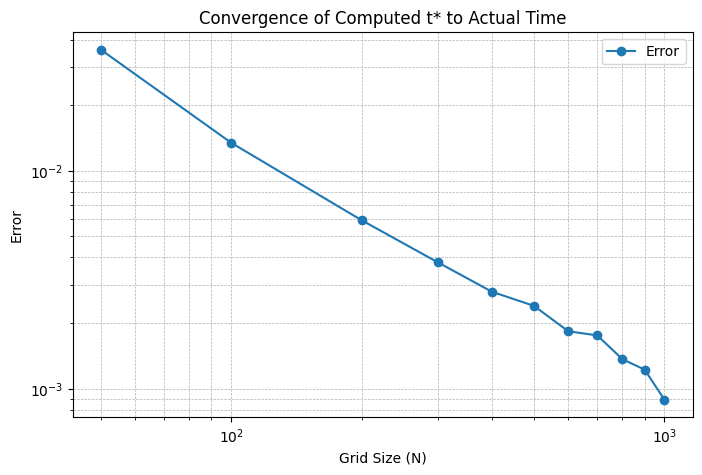

In [6]:
import numpy as np
import matplotlib.pyplot as plt

t_real = 0.424011387033

grid_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
t = []

for N in grid_sizes:

    delta_x = 2 / N
    delta_t = 0.000001
    alpha = 1
    T = 2

    u_0 = np.zeros((N, N), dtype=np.float32)
    u_0[:, 0] = 5

    t_cal = solve_2d_heat_exp_GPU(u_0, T, delta_x, delta_t, alpha, N)

    t.append(t_cal)

errors = [abs(t_cal - t_real) for t_cal in t]

plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, errors, marker="o", label="Error")
plt.xlabel("Grid Size (N)")
plt.ylabel("Error")
plt.title("Convergence of Computed t* to Actual Time")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Comment: Here is the plot about the convergence of computed time t against the actual time.

In [ ]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

# CUDA 内核：显式时间步进
@cuda.jit
def explicit_timestep_2d_kernel(u, u_new, N, r):
    """
    使用显式方法在 GPU 上更新二维网格的温度值。
    """
    i, j = cuda.grid(2)  # 获取当前线程的二维索引
    if 1 <= i < N - 1 and 1 <= j < N - 1:  # 确保只更新内部点
        u_new[i, j] = (
            r * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4 * u[i, j])
            + u[i, j]
        )

# 边界条件更新
@cuda.jit
def apply_boundary_conditions_kernel(u, N):
    """
    在 GPU 上设置边界条件。
    """
    i, j = cuda.grid(2)
    if i == 0 or i == N-1 or j == 0 or j == N-1:
        if j == 0:  # 左边界
            u[i, j] = 5
        else:  # 其他边界
            u[i, j] = 0

# 主函数：测试显式方法的稳定性
def solve_2d_heat_stability_gpu(T, delta_x, delta_t, alpha, N):
    """
    用显式方法在 GPU 上求解二维热方程，并测试稳定性。
    """
    r = alpha * delta_t / delta_x**2
    print(f"Stability parameter r = {r:.4f}")

    # 初始化 GPU 数组
    u = cuda.to_device(np.zeros((N, N), dtype=np.float32))
    u_new = cuda.device_array_like(u)

    # 设置线程块和网格
    threads_per_block = (16, 16)
    blocks_per_grid = (
        (N + threads_per_block[0] - 1) // threads_per_block[0],
        (N + threads_per_block[1] - 1) // threads_per_block[1]
    )

    # 时间步进
    time_steps = int(T / delta_t)
    for t in range(time_steps):
        # 更新边界条件
        apply_boundary_conditions_kernel[blocks_per_grid, threads_per_block](u, N)

        # 显式时间步进
        explicit_timestep_2d_kernel[blocks_per_grid, threads_per_block](u, u_new, N, r)

        # 交换新旧数组
        u, u_new = u_new, u

        # 检查稳定性
        if np.any(np.abs(u.copy_to_host()) > 1e6):  # 假设超过 1e6 表示解发散
            return False, r  # 不稳定

    return True, r  # 稳定

# 测试不同的 delta_t
N = 100  # 网格大小
alpha = 1
T = 0.5
delta_x = 2 / N
delta_t_values = [0.0001, 0.001, 0.01, 0.02]  # 时间步长列表

stability_results = []
for delta_t in delta_t_values:
    print(f"Testing with delta_t = {delta_t:.4f}...")
    is_stable, r = solve_2d_heat_stability_gpu(T, delta_x, delta_t, alpha, N)
    stability_results.append((delta_t, r, is_stable))

# 打印结果
print("\nStability Results:")
for delta_t, r, is_stable in stability_results:
    status = "Stable" if is_stable else "Unstable"
    print(f"delta_t = {delta_t:.4f}, r = {r:.4f}, Status: {status}")

# 可视化稳定性分析
delta_t_values, r_values, stabilities = zip(*stability_results)
stabilities_numeric = [1 if stable else 0 for stable in stabilities]

plt.figure(figsize=(8, 5))
plt.plot(delta_t_values, stabilities_numeric, marker="o", label="Stability")
plt.axhline(0.25, color="red", linestyle="--", label="Stability Limit (r=0.25)")
plt.xlabel("Time Step (delta_t)")
plt.ylabel("Stability (1=Stable, 0=Unstable)")
plt.title("Numerical Stability Analysis of Explicit Scheme (GPU)")
plt.legend()
plt.grid()
plt.show()


Comment: This is the numerical investigation of the stability of the schemes.

In [ ]:
import numpy as np
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve

def build_2d_laplacian_matrix(N):
    """
    构建二维离散拉普拉斯矩阵（稀疏矩阵形式）。
    """
    size = N * N
    main_diag = -4 * np.ones(size)  # 主对角线
    side_diag = np.ones(size - 1)   # 水平相邻
    side_diag[np.arange(1, size) % N == 0] = 0  # 每行的边界点不相连
    up_down_diag = np.ones(size - N)  # 垂直相邻

    diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
    offsets = [0, 1, -1, N, -N]

    lap_2d = diags(diagonals, offsets, format="csr")
    return lap_2d

def solve_implicit(u_0, T, delta_x, delta_t, alpha):
    """
    用隐式方法求解二维热方程，并监测中心点温度达到 u=1 的时间 t^*。
    """
    N = int(len(u_0)**0.5)  # 网格大小 N x N
    r = alpha * delta_t / delta_x**2
    print(f"Stability parameter r = {r:.4f}")

    # 构建二维拉普拉斯矩阵
    A = build_2d_laplacian_matrix(N)

    # 构建 M 矩阵
    M = eye(N * N, format="csr") - r * A

    # 中心点索引
    center_idx = (N // 2) * N + (N // 2)

    # 时间步进
    u = u_0.flatten()  # 展平初始温度场
    time_steps = int(T / delta_t)
    usteps = [u.copy()]
    target_time = None

    for step in range(time_steps):
        # 右端项 b = u^n
        b = u.copy()

        # 解线性方程组 M * u^{n+1} = b
        u = spsolve(M, b)
        usteps.append(u.copy())

        # 检查中心点温度
        if target_time is None and u[center_idx] >= 1:
            target_time = step * delta_t
            break  # 找到 t^* 后可以停止检查

    return np.array(usteps), target_time

# 参数设置
N = 50  # 网格大小
delta_x = 2 / N
delta_t = 0.01
alpha = 1
T = 1.0  # 总时间

# 初始化温度场
u_0 = np.zeros((N, N))
u_0[:, 0] = 5  # 左边界温度为 5
u_0 = u_0.flatten()

# 求解隐式热方程并监测目标时间 t^*
usteps, target_time = solve_implicit(u_0, T, delta_x, delta_t, alpha)

# 打印结果
if target_time is not None:
    print(f"The target time t* (center reaches u=1) is approximately {target_time:.4f} seconds.")
else:
    print("The center temperature did not reach u=1 within the simulation time.")

# 可视化结果
import matplotlib.pyplot as plt
final_temp = usteps[-1].reshape((N, N))
plt.imshow(final_temp, cmap="hot", origin="lower", extent=[-1, 1, -1, 1])
plt.colorbar(label="Temperature")
plt.title("Final Temperature Distribution (Implicit)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Comment: The code above showed an implicit time-stepping method to solve this heat equation.